In [1]:
import os
import sys
import json
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from transformers import BertModel, BertTokenizer

w_dir = %pwd
work_dir = os.path.dirname(w_dir)
work_dir

I0407 02:27:56.940594 140552974911296 file_utils.py:39] PyTorch version 1.1.0 available.


'/work'

In [2]:
sys.path.append(w_dir+'/fgc_support_retri')

In [3]:
from fgc_support_retri.ser_extractor import *
from fgc_support_retri.utils import *
from fgc_support_retri import config
from evaluation.fgc_eval import *
from evaluation.eval import eval_sp_fgc, eval_fgc_atype

In [4]:
model_folder = config.TRAINED_MODELS / "20200406_amatch_EM+sf_lr=2e-5" 

In [5]:
model_folder

PosixPath('/work/fgc_support_retri/results/trainedmodels/20200406_amatch_EM+sf_lr=2e-5')

In [6]:
extractor = AMatch_extractor(model_folder, "EM+sf")

I0407 02:27:59.371538 140552974911296 tokenization_utils.py:375] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt from cache at /root/.cache/torch/transformers/8a0c070123c1f794c42a29c6904beb7c1b8715741e235bee04aca2c7636fc83f.9b42061518a39ca00b8b52059fd2bede8daa613f8a8671500e518a8c29de8c00
I0407 02:28:00.282514 140552974911296 configuration_utils.py:152] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json from cache at /root/.cache/torch/transformers/8a3b1cfe5da58286e12a0f5d7d182b8d6eca88c08e26c332ee3817548cf7e60a.3767c74c8ed285531d04153fe84a0791672aff52f7249b27df341dbce09b8305
I0407 02:28:00.285485 140552974911296 configuration_utils.py:169] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_r

In [7]:
eval_data = json_load(config.FGC_TEST)

In [8]:
get_answer_sp(eval_data, force=True)

100%|██████████| 193/193 [00:00<00:00, 26070.88it/s]


In [9]:
all_sp_predictions = []
all_atype_predictions = []
all_items = []
for d in tqdm(eval_data):
    for q in d['QUESTIONS']:
        sp_preds = []
        sp_scores = []
        sp_preds, _, sp_scores = extractor.predict(q, d)
        assert sp_preds != []
        assert sp_scores != []
        q['sp'] = sp_preds
        q['sp_scores'] = sp_scores

100%|██████████| 193/193 [02:10<00:00,  1.09s/it]


In [10]:
all_items, all_sp_predictions, all_answer_sp = eval_from_threshold(eval_data, threshold=0.5)

100%|██████████| 193/193 [00:00<00:00, 81949.86it/s]


In [11]:
metrics = eval_sp_fgc(all_items, all_sp_predictions)

{'sp_em': 0.258, 'sp_prec': 0.737, 'sp_recall': 0.678, 'sp_f1': 0.651}


In [12]:
metrics = eval_sp_fgc(all_answer_sp, all_sp_predictions)

{'sp_em': 0.226, 'sp_prec': 0.515, 'sp_recall': 0.713, 'sp_f1': 0.534}


In [13]:
from fgc_support_retri.extractor_stage2 import *

In [14]:
all_sp_predictions = []
all_atype_predictions = []
all_items = []
for d in tqdm(eval_data):
    for q in d['QUESTIONS']:
        sp2, sp2_scores = stage2_extract(d, q['sp'], q['sp_scores'])
        q['sp'] = sp2
        q['sp_scores'] = sp2_scores

100%|██████████| 193/193 [00:00<00:00, 7358.90it/s]


In [15]:
all_items, all_sp_predictions, all_answer_sp = eval_from_threshold(eval_data, threshold=0.5)

100%|██████████| 193/193 [00:00<00:00, 56926.91it/s]


In [16]:
metrics = eval_sp_fgc(all_items, all_sp_predictions)

{'sp_em': 0.126, 'sp_prec': 0.586, 'sp_recall': 0.721, 'sp_f1': 0.597}


In [17]:
metrics = eval_sp_fgc(all_answer_sp, all_sp_predictions)

{'sp_em': 0.095, 'sp_prec': 0.392, 'sp_recall': 0.745, 'sp_f1': 0.461}


In [18]:
def get_sent_ie(sp_i, d):
    out_string = ""
    out_string += "sentence{}".format(sp_i) + '\n'
    out_string += d['SENTS'][sp_i]['text'] + '\n'
    for e in d['SENTS'][sp_i]['IE']['NER']:
        out_string += str(e) + '\n'
    return out_string

In [19]:
def print_analysis_from_qid(qid, data):
    for d_i, d in enumerate(data):
        for q in d['QUESTIONS']:
            if q['QID'] == qid:
                print('d_i:{}'.format(d_i))
                print(q['QID'])
                print(q['QTEXT_CN'])
                print(q['sp_scores'])
                print("sent_len:{}".format(len(d['SENTS'])))
                print("atype:{}".format(q['ATYPE']))
                print("SHINT:{}".format(q['SHINT']))
                print("answer_sp:{}".format(q['answer_sp']))
                print("sp:{}".format(q['sp']))
                print()
                all_set = set(q['SHINT']) | set(q['sp'])
                for sp_i in range(min(all_set), max(all_set) + 1):
                    print(q['sp_scores'][sp_i])
                    print(get_sent_ie(sp_i, d))

In [20]:
print_analysis_from_qid('D031Q01', eval_data)

d_i:28
D031Q01
新版的北美贸易协定英文简称为何?
[0.020742785185575485, 0.0021737413480877876, 0.0005869779852218926, 0.31520652770996094, 0.0007627905579283834, 0.015408671461045742, 0.000806327210739255, 0.07138276100158691, 0.48101547360420227, 0.000564411049708724, 0.0004469889390747994, 0.48101547360420227, 0.20939001441001892, 0.018812473863363266, 0.021793726831674576]
sent_len:15
atype:Object
SHINT:[7, 14]
answer_sp:[14]
sp:[8]

0.07138276100158691
sentence7
成为美、加、墨3国去年谈判以期达成一项新的北美贸易协定的重大障碍。
{'id': 'D0-S0-M0', 'string': '美', 'type': 'GPE', 'char_b': 2, 'char_e': 3}
{'id': 'D0-S0-M1', 'string': '加', 'type': 'GPE', 'char_b': 4, 'char_e': 5}
{'id': 'D0-S0-M2', 'string': '墨', 'type': 'GPE', 'char_b': 6, 'char_e': 7}
{'id': 'D0-S0-M3', 'string': '3', 'type': 'NUMBER', 'char_b': 7, 'char_e': 8}
{'id': 'D0-S0-M4', 'string': '去年', 'type': 'DATE', 'char_b': 9, 'char_e': 11}
{'id': 'D0-S0-M5', 'string': '一', 'type': 'NUMBER', 'char_b': 17, 'char_e': 18}
{'id': 'D0-S0-M6', 'string': '北美', 'type': 'LOC', '

# draw intervals

In [21]:
def get_interval_span():
    intervals = []
    last = 0
    step = 10
    for i in range(step):
        now = round(last+1/step, 1)
        intervals.append((last, now))
        last = now
    return intervals

In [22]:
def get_interval(score):
    # get interval span
    intervals = []
    last = 0
    step = 10
    for i in range(step):
        now = round(last+1/step, 1)
        intervals.append((last, now))
        last = now
    
    # get interv_i
    for interv_i, interv in enumerate(intervals):
        if interv[0] <= score < interv[1]:
            return interv_i

In [23]:
def createLabels(data):
    all_height = 0
    for item in data:
        all_height += item.get_height()
    for item in data:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height*1.05, 
            '{}% ({})'.format(int(height/all_height*100), int(height)),
            ha = "center",
            va = "bottom",
        )

In [24]:
intervals = get_interval_span()

In [25]:
interv_scores_p = [0] * 10
interv_scores_n = [0] * 10
interv_scores_answer = [0] * 10
interv_scores_not_answer = [0] * 10
for document in eval_data:
    for question in document['QUESTIONS']:
        if not question['SHINT']:
            continue
        for sent_i, sp_score in enumerate(question['sp_scores']):
            if sent_i in question['SHINT']:
                interv_scores_p[get_interval(sp_score)] += 1
                if sent_i in question['answer_sp']:
                    interv_scores_answer[get_interval(sp_score)] += 1
                else:
                    interv_scores_not_answer[get_interval(sp_score)] += 1
            else:
                interv_scores_n[get_interval(sp_score)] += 1

I0406 01:52:26.908480 140300218378048 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0406 01:52:26.910680 140300218378048 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'all sp')

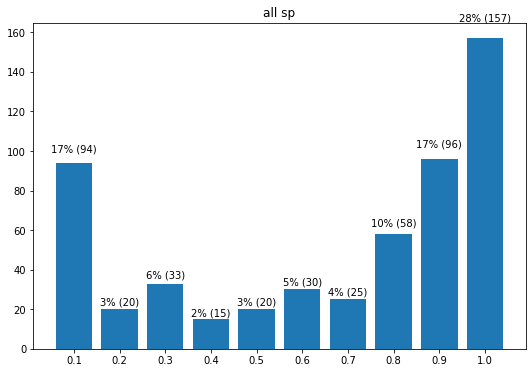

In [26]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
A = plt.bar([str(interv[1]) for interv in intervals], interv_scores_p)
createLabels(A)
plt.title('all sp')

I0406 01:52:27.244924 140300218378048 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0406 01:52:27.247107 140300218378048 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'not sp')

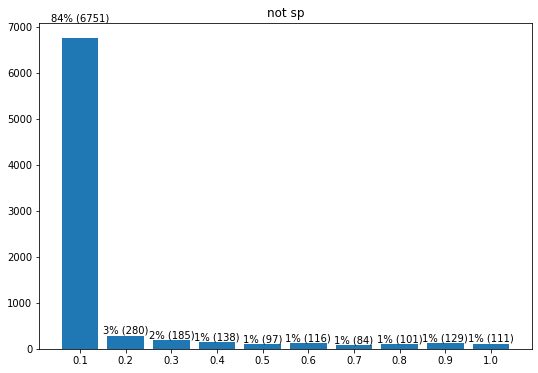

In [27]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_n)
createLabels(B)
plt.title('not sp')

I0406 01:52:27.554749 140300218378048 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0406 01:52:27.556846 140300218378048 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'answer sp')

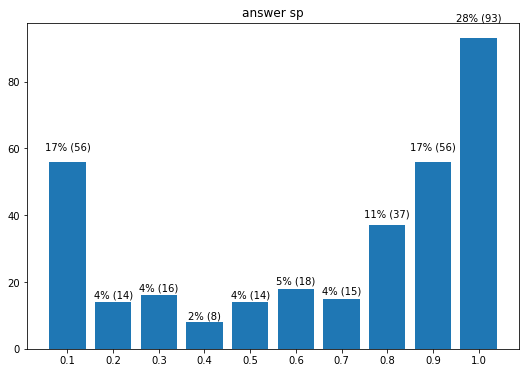

In [28]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_answer)
createLabels(B)
plt.title('answer sp')

I0406 01:52:27.849059 140300218378048 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0406 01:52:27.850770 140300218378048 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'not answer sp')

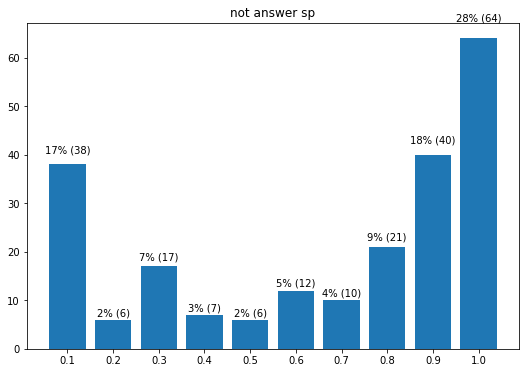

In [29]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_not_answer)
createLabels(B)
plt.title('not answer sp')

# Write output

In [13]:
json_write(eval_data, 'prediction/ematch+sf_dev.json')